# Import Libaries

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
import csv, datetime, uuid, time

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

# Reproducibility

In [162]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Load & sort data

In [163]:
ticker = "AAPL"
df = pd.read_csv(f'..\..\data\processed\{ticker}_processed_data_full.csv', parse_dates=['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
print(df.head(), df.columns)

        Date      Close       High        Low       Open     Volume     Target
0 2017-01-03  26.862425  26.904054  26.540955  26.781479  115127600  26.832355
1 2017-01-04  26.832355  26.945681  26.769912  26.793039   84472400  26.968815
2 2017-01-05  26.968815  27.026633  26.783795  26.809235   88774400  27.269468
3 2017-01-06  27.269468  27.327287  26.936434  27.008128  127007600  27.519241
4 2017-01-09  27.519241  27.621002  27.276405  27.278717  134247600  27.546997 Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target'], dtype='object')


# Feature Engineering

## One-Day Return
- Is simply the percentage change in price from one day to the next
- Helps pick up on the rate of change in the market rather than raw price levels
- Scale‐invariance: Returns normalize price changes into a small, stable range so the model isn’t thrown off by the stock’s overall price drift.
- Momentum & mean‐reversion: Returns capture serial correlation, helping the network spot short‐lived trends and reversals.
- Stationarity: Returns have steadier statistics over time than raw prices, which makes neural‐net training more stable.

In [164]:
df['Return'] = df['Close'].pct_change()
df = df.dropna(subset=['Return'])   # drop first row

# 10-day Exponential Moving Average (EMA-10)
- Emphasizes recent moves: unlike a simple moving average, an EMA gives exponentially more weight to the latest days, so it reacts faster to new trends.
- Filters noise: it smooths out day-to-day volatility so your model can see the underlying short-term trend more clearly.
- Captures momentum: crossing patterns (e.g. price above vs. below its EMA) are classic signals for up- or down-momentum.

In [165]:
df["EMA10"] = df["Close"].ewm(span=10, adjust=False).mean()

# Drop the initial NaNs from the EMA calculation
df = df.dropna(subset=["EMA10"]).reset_index(drop=True)

## 20-Day Rolling Volatility
Gives DNN “a sense” of how choppy the market has been. When volatility is high, your model will know to expect bigger swings and adjust its predictions (helping correct that over-prediction bias).

In [166]:
WINDOW_VOL = 20
df['Volatility20'] = df['Return'].rolling(window=WINDOW_VOL).std()

# Drop the initial rows that have NaN volatility  
df = df.dropna(subset=['Volatility20']).reset_index(drop=True)

## 20-Day Exponential Moving Average (EMA20)
- Exponential Moving Average over 20 days (slower trend)
- Gives a medium‐term trend line—smoother than raw price but more responsive than a 50-day MA—helping the model see emerging up- or down-trends.
- augments your EMA10 with a broader view of trend.

In [167]:
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df = df.dropna(subset=["EMA20"]).reset_index(drop=True)

## 14-day Relative Strength Index (RSI14)
- Relative Strength Index over 14 days
- Captures over-bought (>70) or over-sold (<30) conditions—i.e. momentum extremes—which often precede short-term reversals
- flags extreme momentum turns that raw returns might miss.

In [168]:
delta      = df['Close'].diff()
up, down   = delta.clip(lower=0), -delta.clip(upper=0)
roll_up    = up.ewm(span=14, adjust=False).mean()
roll_down  = down.ewm(span=14, adjust=False).mean()
rs         = roll_up / roll_down
df['RSI14'] = 100 - (100 / (1 + rs))

df = df.dropna(subset=["RSI14"]).reset_index(drop=True)

## Moving Average Convergence/Divergence (MACD)
-  Highlights shifts in momentum by comparing fast vs. slow trends; a rising MACD means short-term strength is outpacing the longer trend
- capture both the magnitude and timing of momentum shifts.

In [169]:
ema12 = df['Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD']        = ema12 - ema26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df = df.dropna(subset=['MACD','MACD_signal']).reset_index(drop=True)

# Chronological 60 / 20 / 20 split

In [170]:
n       = len(df)
i_train = int(0.6  * n)    # first 60% → train
i_val   = int(0.8  * n)    # next 20% → val
# last 20% → test

train_df = df.iloc[:i_train].copy()
val_df   = df.iloc[i_train:i_val].copy()
test_df  = df.iloc[i_val:].copy()


# Scale Features

In [171]:
feature_cols = [ # can be modified
    'Close',
    'Return',
    'Volume',
    'EMA10',        
    'Volatility20',
    'EMA20',
    'RSI14',
    'MACD',
    'MACD_signal'
] 

target_col = "Target"

scaler = StandardScaler().fit(train_df[feature_cols])
X_tr = scaler.transform(train_df[feature_cols])
X_va = scaler.transform(val_df[feature_cols])
X_te = scaler.transform(test_df[feature_cols])

y_tr = train_df[target_col].values
y_va = val_df[target_col].values
y_te = test_df[target_col].values

# Create Sliding Windows

In [172]:
def make_windows(X, y, W):
    Xs, ys = [], []
    for i in range(W, len(X)):
        Xs.append(X[i-W:i].flatten())  # flatten (W × n_features) → vector
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 20   # 20-day look-back
X_train, y_train = make_windows(X_tr, y_tr, window_size)
X_val,   y_val   = make_windows(X_va, y_va, window_size)
X_test,  y_test  = make_windows(X_te, y_te, window_size)

# Define DNN

In [173]:
description = "Upgraded to 2-layer DNN with BatchNorm & Dropout, increased to 100 epochs" # for logging
layers = "1st layer: 128, 2nd layer: 64"
dropout = 0.2
learning_rate_num = 1e-3

model = Sequential([
    Dense(128, activation="relu",
          input_shape=(window_size * len(feature_cols),)),
    BatchNormalization(),
    Dense(64, activation="relu"),
    Dropout(dropout),
    Dense(1)  # regression output
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_num),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

model.summary()
num_params = model.count_params() # for logging

c:\Users\diana\Documents\Current Classes\Artificial Intelligence - COSC 4368\Course Project\stock-market-prediction-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,001 (125.00 KB)

 Trainable params: 31,745 (124.00 KB)

 Non-trainable params: 256 (1.00 KB)

# Train with early-stopping

In [174]:
start_time = time.time() # for logging

batch_size_input = 32

es = EarlyStopping(
    monitor="val_rmse",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size_input,
    callbacks=[es],
    verbose=2
)

train_time = round(time.time() - start_time, 2) # for logging
epochs_run = len(history.history["loss"]) # for logging 
val_rmse   = history.history["val_rmse"][-1] # for logging
train_rmse = history.history["rmse"][-1] # for logging

Epoch 1/100
37/37 - 1s - 39ms/step - loss: 5195.5781 - rmse: 72.0804 - val_loss: 11968.5957 - val_rmse: 109.4011
Epoch 2/100
37/37 - 0s - 3ms/step - loss: 2436.7629 - rmse: 49.3636 - val_loss: 305.4632 - val_rmse: 17.4775
Epoch 3/100
37/37 - 0s - 3ms/step - loss: 815.0264 - rmse: 28.5487 - val_loss: 341.2973 - val_rmse: 18.4742
Epoch 4/100
37/37 - 0s - 3ms/step - loss: 541.0109 - rmse: 23.2596 - val_loss: 54.2901 - val_rmse: 7.3682
Epoch 5/100
37/37 - 0s - 3ms/step - loss: 470.8566 - rmse: 21.6992 - val_loss: 109.3538 - val_rmse: 10.4572
Epoch 6/100
37/37 - 0s - 3ms/step - loss: 386.1871 - rmse: 19.6516 - val_loss: 72.7011 - val_rmse: 8.5265
Epoch 7/100
37/37 - 0s - 3ms/step - loss: 324.6847 - rmse: 18.0190 - val_loss: 184.1873 - val_rmse: 13.5716
Epoch 8/100
37/37 - 0s - 3ms/step - loss: 277.6751 - rmse: 16.6636 - val_loss: 180.5788 - val_rmse: 13.4380
Epoch 9/100
37/37 - 0s - 3ms/step - loss: 257.7460 - rmse: 16.0545 - val_loss: 100.6421 - val_rmse: 10.0321


# Evaluate on test set

In [175]:
test_loss, test_rmse = model.evaluate(X_test, y_test, verbose=0) # for logging
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Val RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 16.0545
Val RMSE: 10.0321
Test RMSE: 9.4561


# Log your experiment

In [176]:
exp_id = uuid.uuid4().hex[:8]
run_date = datetime.date.today()

exp_dir  = Path.cwd() / "experiments"
csv_path = exp_dir / f"{ticker}_experiments.csv"

with csv_path.open("a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        exp_id,
        run_date,
        description,
        window_size,
        feature_cols,
        layers,
        dropout, 
        learning_rate_num,
        batch_size_input,
        epochs_run,
        num_params,
        train_time, 
        train_rmse,                
        val_rmse,
        test_rmse
    ])
print(f"Logged experiment {exp_id}")

Logged experiment 5cbbd6fb


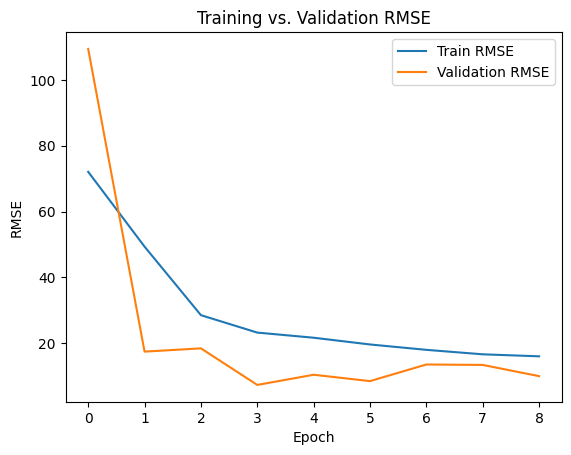

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


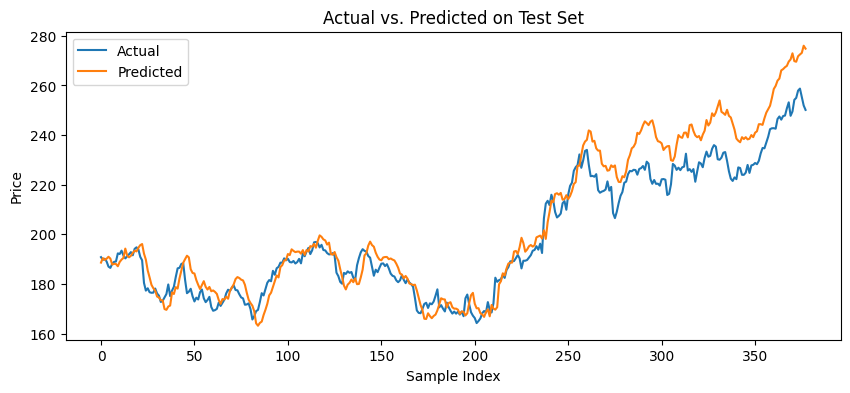

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


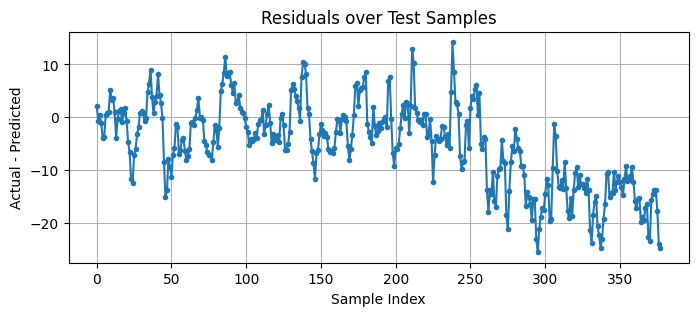

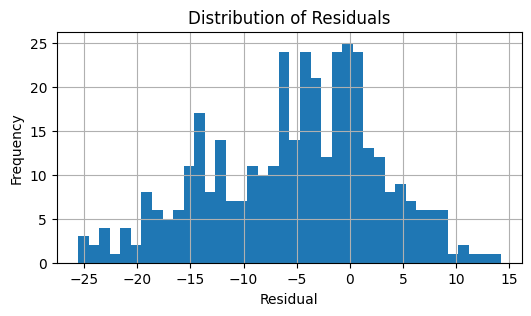

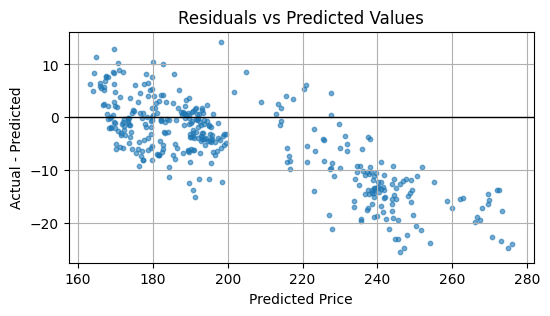

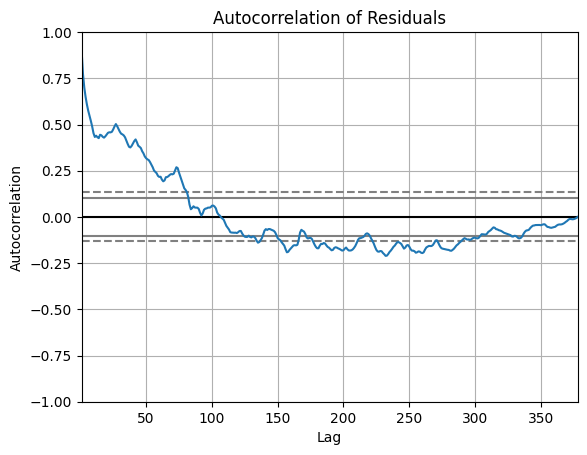

In [177]:
# 1. Plot training vs. validation RMSE over epochs
plt.figure()
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training vs. Validation RMSE')
plt.legend()
plt.show()

# 2. Plot actual vs. predicted on the test set
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted on Test Set')
plt.legend()
plt.show()

# 3. Plot residuals
# Ensure required variables exist
required_vars = ('model', 'X_test', 'y_test')
missing = [var for var in required_vars if var not in globals()]
if missing:
    raise RuntimeError(f"Cannot plot residuals: missing variables {missing}. "
                       f"Please run this cell after defining 'model', 'X_test', and 'y_test'.")

# 1) Recompute predictions and flatten to 1D
y_pred = model.predict(X_test).flatten()

# 2) Check shapes
# print("y_test shape:",  y_test.shape)
# print("y_pred shape:", y_pred.shape)

# 3) Build residuals
residuals = y_test - y_pred
# print("residuals shape:", residuals.shape)

# 4) Plot residuals over test samples
plt.figure(figsize=(8, 3))
plt.plot(residuals, marker='o', markersize=3, linestyle='-')
plt.title('Residuals over Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Actual - Predicted')
plt.grid(True)
plt.show()

# 5) Plot histogram of residuals
plt.figure(figsize=(6, 3))
plt.hist(residuals, bins=40)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 6) Plot residuals vs. predicted values
plt.figure(figsize=(6, 3))
plt.scatter(y_pred, residuals, s=10, alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Price')
plt.ylabel('Actual - Predicted')
plt.grid(True)
plt.show()

# 7) Autocorrelation of residuals
pd.plotting.autocorrelation_plot(pd.Series(residuals))
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


